# Detecting generated scientific papers

Competition [website here...](https://www.kaggle.com/competitions/detecting-generated-scientific-papers/overview)

### Description
This competition is a part of the shared task hosted within the third workshop on Scholarly Document Processing ([SDP 2022](https://sdproc.org/2022/)), being held in association with the 29th International Conference on Computational Linguistics ([COLING 2022](https://coling2022.org/)).

There are increasing reports that research papers can be written by computers, which presents a series of concerns (e.g., see [1]). In this challenge, we explore the state of the art in detecting automatically generated papers. We frame the detection problem as a binary classification task: given an excerpt of text, label it as either human-written or machine-generated. We provide a corpus of over 5000 excerpts from automatically written papers, based on the work by Cabanac et al. [2], as well as documents collected by Elsevier publishing and editorial teams. As a control set, we provide a 5x larger corpus of openly accessible human-written as well as generated papers from the same scientific domains of documents. We also encourage contributions that aim to extend this dataset with other computer-generated scientific papers, or papers that propose valid metrics to assess automatically generated papers against those written by humans.

### Acknowledgements
We thank Cyril Labbé, Basile Dubois-Binnaire, Guillaume Cabanac, and Alexander Magazinov for their input in the ideation phase of the task preparation.

### Links
[1] Holly Else. (2021). ["'Tortured phrases' give away fabricated research papers."](https://www.nature.com/articles/d41586-021-02134-0) Nature.

[2] Guillaume Cabanac, Cyril Labbé, and Alexander Magazinov. (2021). ["Tortured phrases: A dubious writing style emerging in science. Evidence of critical issues affecting established journals."](https://arxiv.org/abs/2107.06751)

# Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os, re

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
#from transformers import TFBertModel
#import transformers

print(tf.version.VERSION)

2.6.4


In [2]:
!pip install transformers

In [3]:
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig, TFBertModel

# Loading data

In [4]:
train = pd.read_csv("../input/detecting-generated-scientific-papers/fake_papers_train_part_public.csv")
test = pd.read_csv("../input/detecting-generated-scientific-papers/fake_papers_test_public.csv")

train.shape, test.shape

((5350, 3), (21403, 2))

In [5]:
train.head()

,id,text,fake
0,1,Modern two-dimensional imaging is of such qual...,0
1,2,Background: The optimal sequence of systemic p...,1
2,5,This chapter opens with a discussion of the ef...,1
3,10,The time scale of the ultra-short-term can str...,1
4,23,Electronic nose or machine olfaction are syste...,1


- Checking Missing Values

In [6]:
train.isna().sum().any(), test.isna().sum().any()

(False, False)

- Checking target distribution

In [7]:
train["fake"].value_counts()

1    3664
0    1686
Name: fake, dtype: int64

In [8]:
#"[CLS]" + train.text + "[SEP]"

# Pre-processing Data

In [9]:
replic = train.head().copy()
replic

,id,text,fake
0,1,Modern two-dimensional imaging is of such qual...,0
1,2,Background: The optimal sequence of systemic p...,1
2,5,This chapter opens with a discussion of the ef...,1
3,10,The time scale of the ultra-short-term can str...,1
4,23,Electronic nose or machine olfaction are syste...,1


In [10]:
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()
        #return document

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)
        return preprocessed_text

train.text = train.text.apply(preprocess_text)
train

,id,text,fake
0,1,modern dimensional imaging such quality that e...,0
1,2,background optimal sequence systemic palliativ...,1
2,5,this chapter open with discussion effect long ...,1
3,10,time scale ultra short term strengthen diverse...,1
4,23,electronic nose machine olfaction system used ...,1
...,...,...,...
5345,26727,this paper shmoop statistical method derive er...,1
5346,26728,this paper author examine effect surgical ster...,1
5347,26734,possibility using mezzanine card pmcs module o...,0
5348,26743,soil biodiversity keystone natural world this ...,1


### Configuration

In [11]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
BATCH_SIZE = 16
MAX_LEN = 256

### Bert Encoder

In [12]:
def bert_encode(texts, tokenizer, max_len=MAX_LEN):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    
    for text in texts:
        """
        token = tokenizer(text, max_length=max_len, truncation=True, padding='max_length',
                         add_special_tokens=True)
        """
        token = tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        
        input_ids.append(token['input_ids'])
        token_type_ids.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    
    return np.array(input_ids), np.array(token_type_ids), np.array(attention_mask)

### Loading bert tokenizer

In [13]:
bert = "../input/huggingface-bert-variants/bert-base-cased/bert-base-cased" #"bert-base-uncased" 
tokenizer = BertTokenizer.from_pretrained(bert)#, do_lower_case=True)

In [14]:
"""
bert_large = '../input/huggingface-bert-variants/bert-large-cased/bert-large-cased'
bert_base = '../input/huggingface-bert-variants/bert-base-cased/bert-base-cased'
bert_base_uncased = '../input/huggingface-bert-variants/bert-base-uncased'
distilbert_base = '../input/huggingface-bert-variants/distilbert-base-cased/distilbert-base-cased'
distilbert_base_squad = '../input/huggingface-bert-variants/distilbert-base-cased-distilled-squad/distilbert-base-cased-distilled-squad'

#tokenizer = transformers.BertTokenizer.from_pretrained(bert_base_uncased)
#tokenizer.save_pretrained('.')
"""

"\nbert_large = '../input/huggingface-bert-variants/bert-large-cased/bert-large-cased'\nbert_base = '../input/huggingface-bert-variants/bert-base-cased/bert-base-cased'\nbert_base_uncased = '../input/huggingface-bert-variants/bert-base-uncased'\ndistilbert_base = '../input/huggingface-bert-variants/distilbert-base-cased/distilbert-base-cased'\ndistilbert_base_squad = '../input/huggingface-bert-variants/distilbert-base-cased-distilled-squad/distilbert-base-cased-distilled-squad'\n\n#tokenizer = transformers.BertTokenizer.from_pretrained(bert_base_uncased)\n#tokenizer.save_pretrained('.')\n"

### Splitting Data

In [15]:
y = train.pop('fake')
y

0       0
1       1
2       1
3       1
4       1
       ..
5345    1
5346    1
5347    0
5348    1
5349    1
Name: fake, Length: 5350, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train['text'], y, test_size=0.06, random_state=42, shuffle=True, stratify=y)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((5029,), (321,), (5029,), (321,))

### bert encoding train and valid data

In [17]:
X_train = bert_encode(X_train.astype(str), tokenizer)
X_valid = bert_encode(X_valid.astype(str), tokenizer)

y_train = y_train.values
y_valid = y_valid.values

In [18]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

2022-07-26 11:47:26.094530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 11:47:26.095591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 11:47:26.096251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 11:47:26.099329: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### Setup GPU

In [19]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


# Modeling

In [20]:
def build_model(bert_model, max_len=MAX_LEN):    
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    sequence_output = bert_model.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    clf_output = sequence_output[:, 0, :]
    clf_output = Dropout(.1)(clf_output)
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(Adam(learning_rate=1e-5), loss='binary_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.Precision(),]
                 )
    
    return model

In [21]:
def build_model2(bert_model, max_len=MAX_LEN):    
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    input_masks_ids = Input(shape=(max_len,), dtype=tf.int32, name="masked_token")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    sequence_output = bert_model.bert(input_ids, attention_mask=input_masks_ids, token_type_ids=segment_ids)[0]
    clf_output = sequence_output[:, 0, :]
    clf_output = Dropout(.1)(clf_output)
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_ids, input_masks_ids, segment_ids], outputs=out)
    model.compile(Adam(learning_rate=1e-5), loss='binary_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.Precision(),]
                 )
    
    return model

In [22]:
%%time
# Define Bert Config
#config = BertConfig.from_pretrained(bert, #output_hidden_states=True, 
                                    #hidden_dropout_prob=0.2, attention_probs_dropout_prob=0.2
#                                   )

# Define Bert Model
#transformer_model = TFBertForSequenceClassification.from_pretrained(bert, config=config)

transformer_model = (TFBertModel.from_pretrained(bert))

# Define Keras Model
model = build_model(transformer_model, max_len=MAX_LEN)
model.summary()

Some layers from the model checkpoint at ../input/huggingface-bert-variants/bert-base-cased/bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at ../input/huggingface-bert-variants/bert-base-cased/bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]         

### Training

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.7,
    patience=1, #min_lr=1357e-6
)

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    steps_per_epoch=240,
    #batch_size=512,
    epochs=32,
    callbacks=[early_stopping, reduce_lr],
    #verbose=0

)

Epoch 1/32


2022-07-26 11:47:52.656992: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


240/240 [==============================] - 142s 534ms/step - loss: 0.4052 - accuracy: 0.8120 - precision: 0.8344 - val_loss: 0.3010 - val_accuracy: 0.8910 - val_precision: 0.8715
Epoch 2/32
240/240 [==============================] - 124s 517ms/step - loss: 0.1627 - accuracy: 0.9378 - precision: 0.9479 - val_loss: 0.1745 - val_accuracy: 0.9283 - val_precision: 0.9457
Epoch 3/32
240/240 [==============================] - 124s 517ms/step - loss: 0.0919 - accuracy: 0.9664 - precision: 0.9745 - val_loss: 0.1550 - val_accuracy: 0.9470 - val_precision: 0.9552
Epoch 4/32
240/240 [==============================] - 124s 517ms/step - loss: 0.0688 - accuracy: 0.9747 - precision: 0.9809 - val_loss: 0.1678 - val_accuracy: 0.9439 - val_precision: 0.9509
Epoch 5/32
240/240 [==============================] - 124s 517ms/step - loss: 0.0326 - accuracy: 0.9885 - precision: 0.9920 - val_loss: 0.2044 - val_accuracy: 0.9502 - val_precision: 0.9435
Epoch 6/32
240/240 [==============================] - 124s 51

Best Validation Loss: 0.1550
Best Validation Accuracy: 0.9533
Best Validation Precision: 0.9638


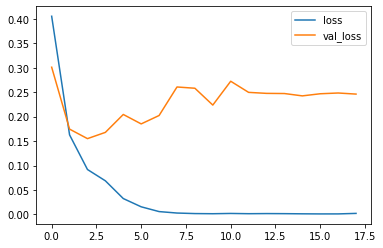

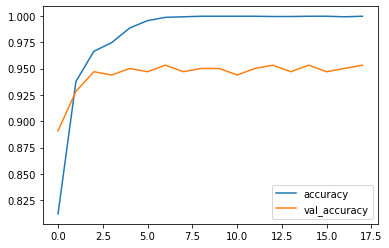

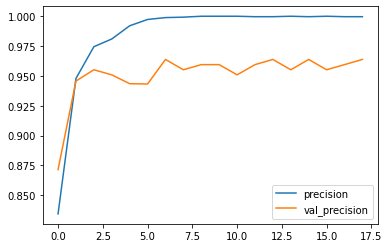

In [24]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 1
history_df.loc[0:, ['loss', 'val_loss']].plot()
history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()
history_df.loc[0:, ['precision', 'val_precision']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}" +\
      "\nBest Validation Precision: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max(),
             history_df['val_precision'].max()))

### Saving Model

In [25]:
model.save('dgsp_keras_model.v1')

2022-07-26 12:25:22.950024: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Test Prediction

In [26]:
%%time
# Processing
test.text = test.text.apply(preprocess_text)

# Encoding
test_text = bert_encode(test.text.astype(str), tokenizer)

CPU times: user 1min 31s, sys: 0 ns, total: 1min 31s
Wall time: 1min 31s


In [27]:
preds = model.predict(test_text, verbose=1)
preds

669/669 [==============================] - 212s 313ms/step


array([[0.99972063],
       [0.9999404 ],
       [0.9988065 ],
       ...,
       [0.99998546],
       [0.99995434],
       [0.6572295 ]], dtype=float32)

# Submission

- Saving with Threshold >= 0.5

In [28]:
sub = pd.read_csv('../input/detecting-generated-scientific-papers/sample_submission.csv')
sub['fake'] = (preds >= 0.5).astype(int)

sub.to_csv("submission.csv", index=False)
sub['fake'].value_counts()

1    14792
0     6611
Name: fake, dtype: int64

- Saving With Threshold  0.45 to 0.15

In [29]:
Thresholds = [0.6, 0.575, 0.55, 0.525, 0.475, 0.45, 0.425, 0.4, 0.375, 0.35]

for tresh in Thresholds:
    sub['fake'] = (preds >= tresh).astype(int)
    sub.to_csv(f"submission_trsh_{tresh}.csv", index=False)
    print(f"=== Threshold {tresh} === \n{sub['fake'].value_counts()} \n")

=== Threshold 0.6 === 
1    14653
0     6750
Name: fake, dtype: int64 

=== Threshold 0.575 === 
1    14682
0     6721
Name: fake, dtype: int64 

=== Threshold 0.55 === 
1    14720
0     6683
Name: fake, dtype: int64 

=== Threshold 0.525 === 
1    14761
0     6642
Name: fake, dtype: int64 

=== Threshold 0.475 === 
1    14836
0     6567
Name: fake, dtype: int64 

=== Threshold 0.45 === 
1    14866
0     6537
Name: fake, dtype: int64 

=== Threshold 0.425 === 
1    14891
0     6512
Name: fake, dtype: int64 

=== Threshold 0.4 === 
1    14931
0     6472
Name: fake, dtype: int64 

=== Threshold 0.375 === 
1    14961
0     6442
Name: fake, dtype: int64 

=== Threshold 0.35 === 
1    14994
0     6409
Name: fake, dtype: int64 

